### Is there a better way? 

Yes, I think so! But I'm biased, let's run some code and see what happens.

This next cell is my favorite line of code, nvidia-smi. I think I used this a million times during graduate school and still use it today.

What we are looking at here is that our GPU has nothing on it's memory. 

In [1]:
!nvidia-smi

Mon Jun  9 00:36:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:00:03.0 Off |                    0 |
| N/A   66C    P8             20W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Let's load in our libraries. You can see, we have different libraries - why? NVIDIA has a suite of open-source software libraries and APIs designed to accelerate end-to-end data science and analytics pipelines by leveraging the power of the GPUs - called RAPIDS. 

RAPIDS [https://rapids.ai/] Here we are going to work with two of tese libraries - cuDF and cuML which are the GPU equivalents of pandas and sklearn respectfully.

In [2]:
import cudf
from cuml.cluster import KMeans
from cuml.manifold import TSNE
from cuml.manifold import UMAP


With those loaded, let's check out how fast we can read in our files now. 

In [10]:
%%time
## Read in the data
embeddings_df = cudf.read_parquet('embeddings2025/embeddings.parquet')
captions_df   = cudf.read_parquet('embeddings2025/captions.parquet')

# Pandas took 6.9s GPU took 1.02s, 1.23s, 768ms, 802ms, 906ms

CPU times: user 781 ms, sys: 953 ms, total: 1.73 s
Wall time: 1.01 s


Now I noticed sometimes there was some sticking of this read, I got everywhere from 750ms to 1.2 consistenly, but sometimes I'd get a larger time - which I found odd. But, if you get a longer wait time, just rerun it and what we see is that read is increidbly fast. Waiting for RAPIDS folks to give me a reason why that happened.

Let's look at the best line of code again.

In [4]:
!nvidia-smi

Mon Jun  9 00:16:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:00:03.0 Off |                    0 |
| N/A   66C    P0             34W /   72W |    3907MiB /  23034MiB |     61%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Now we have data on the GPU. This is great! Some of you might be asking the question of why our 2.6GB dataset we have in parquet are now 3.9GB. It's from the file format we chose, parquet. It will compress the data for you if it can, Leading to smaller files in which y ou get faster IO at the cost of needing to decompress. Network/storage IO is usually much smaller than the gpu bandwidth which means that you can sacrifice some time/use on the gpu to make it worth while. 

In case you're worried about the file type, here are some of the file types cuDF supports [https://docs.rapids.ai/api/cudf/latest/user_guide/api_docs/io/] 

Okay, let's look at the data shape again and precision to make sure nothing is different than before. 

In [12]:
X_embeddings=embeddings_df.values
print(X_embeddings.shape)
print(X_embeddings.dtype)

(652671, 768)
float32


### Clustering again!

Few things you're notice: first, code look identical to sklearn's KMeans. That's on purpose, the RAPIDS goal is to get the GPU accelerated version of CPU libraries as one-to-one as possible. Sometimes it's not possible, but we are close to 90% there. 

In [13]:
%%time
## KMeans on all the data
# 1. Instantiate the model
kmeans = KMeans(
    n_clusters=10, #10 clusters start, then 300 cluster
    random_state=0)

# 2. Fit and predict cluster labels
kmeans_labels = kmeans.fit_predict(X_embeddings)  

# 3. Inspect results
kmeans_centroids = kmeans.cluster_centers_
print("Labels:", kmeans_labels)


Labels: [8 1 4 ... 2 3 0]
CPU times: user 828 ms, sys: 33.7 ms, total: 862 ms
Wall time: 875 ms


Yup ... less than a second. That's all good, but we want to focus on 300 clusters don't we? Let's change the clusters above and run it again.

### UMAP

Let's revisit our UMAP problem. I want to take in the 768d data set and get it down to 2d like we talked about before.

Fingers crossed this runs quicker than the 35+ minutes before, because I'm going to ask you to hit run and let it spin.

In [17]:
%%time

# Instantiate GPU UMAP for 2 components
umap_gpu_2D = UMAP(
    n_components=2,       # embed into 2D space
    n_neighbors=30,       # size of local neighborhood
    min_dist=0.5,         # how tightly points are packed
)

# Fit and transform on GPU
X_umap_gpu_2D = umap_gpu_2D.fit_transform(X_embeddings)  # returns CuPy array


CPU times: user 1min 10s, sys: 1.8 s, total: 1min 11s
Wall time: 23.6 s


Not bad! I would gladly run this a few times a day to see how my embeddings are looking. 

But... what about that 3d case? 

In [8]:
%%time

# Instantiate GPU UMAP for 3 components
umap_gpu_3D = UMAP(
    n_components=3,       # embed into 3D space
    n_neighbors=30,       # size of local neighborhood
    min_dist=0.5,         # how tightly points are packed
)

# Fit and transform on GPU
X_umap_gpu_3D = umap_gpu_3D.fit_transform(X_embeddings)  # returns CuPy array


[2025-06-09 00:17:24.601] [CUML] [info] Building knn graph using nn descent
CPU times: user 1min 10s, sys: 1.54 s, total: 1min 11s
Wall time: 23.7 s


I'll take it! 

Let's revisit tSNE again too. It's not going to be lightning fast like above, so for the next couple minutes, let's look at more RAPIDS information on the homepage. 

In [9]:
%%time

# 1. Instantiate GPU t-SNE
tsne = TSNE(
    n_components=2,          # target dimensionality (only 2 supported currently)
    perplexity=30,           # neighbors considered in high-D space (5-50) default 30
    learning_rate=200,       # typical: 10–1000 default 200
    n_iter=1000,             # optimization steps
    method='barnes_hut',     # fast approximation, default - same as UMap library
)

# 2. Fit and transform on GPU
X_tsne_gpu = tsne.fit_transform(X_embeddings)  # returns a CuPy array [1]


[2025-06-09 00:17:48.316] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1min 57s, sys: 6.06 s, total: 2min 3s
Wall time: 2min 2s


We would need to tune this a bit, but we got the point across I hope.

### Speedup
I took some of the CPU runs and compared it to GPU runs. These aren't cherried picked, I ran them all multiple times to get an average time of each instance. Let's look at this graph.

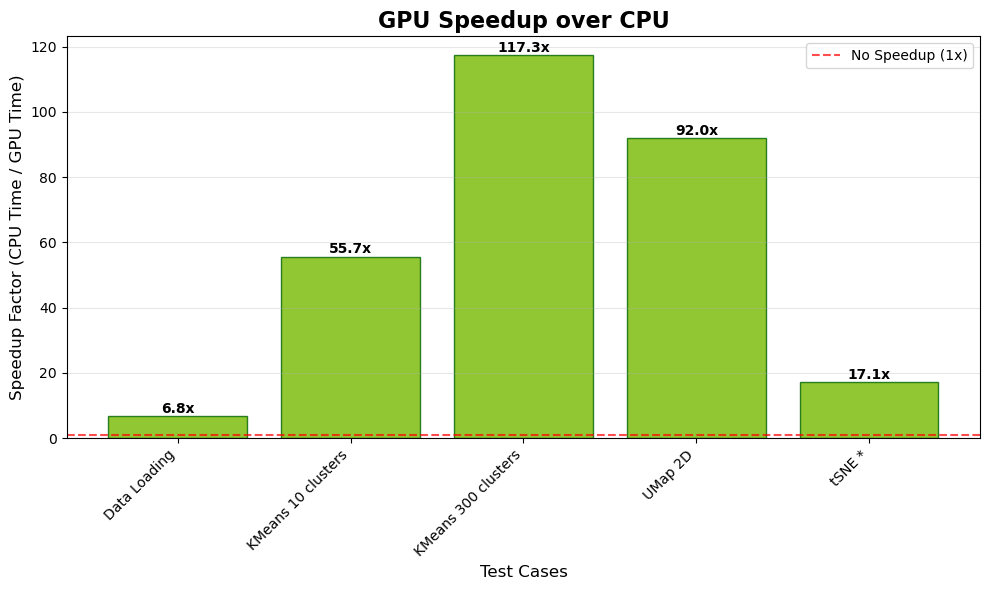

Speedup Summary:
Data Loading: CPU=6.9s, GPU=1.0s, Speedup=6.8x
KMeans 10 clusters: CPU=48.7s, GPU=0.9s, Speedup=55.7x
KMeans 300 clusters: CPU=1314.0s, GPU=11.2s, Speedup=117.3x
UMap 2D: CPU=2172.0s, GPU=23.6s, Speedup=92.0x
tSNE *: CPU=2154.0s, GPU=126.0s, Speedup=17.1x


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Insert your times here (in seconds)
cpu_times = [6.9, 48.7, 21.9*60, 36.2*60, 35.9*60]  # Replace with your CPU times
gpu_times = [1.01, 0.875, 11.2, 23.6, 2.1*60]      # Replace with your GPU times

# Calculate speedup (CPU time / GPU time)
speedup = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]

# Custom labels for your test cases
test_cases = ['Data Loading', 'KMeans 10 clusters', 'KMeans 300 clusters', 'UMap 2D', 'tSNE *']

# NVIDIA green color 
nvidia_green = '#76B900'    

# Choose your preferred darker color
bar_color = nvidia_green  # Change to forest_green for even darker

# Create the speedup plot
plt.figure(figsize=(10, 6))
bars = plt.bar(test_cases, speedup, color=bar_color, edgecolor='darkgreen', alpha=0.8)

# Add value labels on top of bars
for i, (bar, speed) in enumerate(zip(bars, speedup)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{speed:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.title('GPU Speedup over CPU', fontsize=16, fontweight='bold')
plt.ylabel('Speedup Factor (CPU Time / GPU Time)', fontsize=12)
plt.xlabel('Test Cases', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Rotate x-axis labels if they're long
plt.xticks(rotation=45, ha='right')

# Add a horizontal line at 1x (no speedup)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No Speedup (1x)')
plt.legend()

plt.tight_layout()
plt.show()

# Print speedup summary with custom labels
print("Speedup Summary:")
for i, (label, cpu, gpu, speed) in enumerate(zip(test_cases, cpu_times, gpu_times, speedup)):
    print(f"{label}: CPU={cpu:.1f}s, GPU={gpu:.1f}s, Speedup={speed:.1f}x")


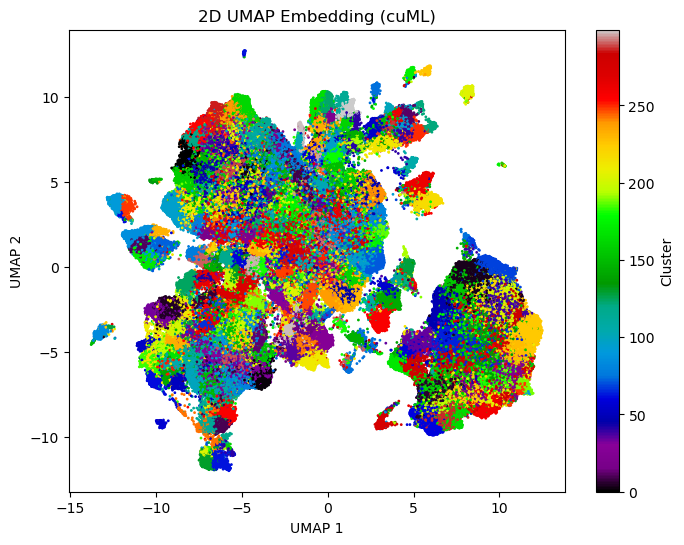

In [10]:
import matplotlib.pyplot as plt
# 1. Transfer to NumPy
X_umap_2D = X_umap_gpu_2D.get()  # shape = (n_samples, 2)
num_labels = 300
cmap = plt.get_cmap('nipy_spectral', num_labels)

# 2. Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    X_umap_2D[:, 0], X_umap_2D[:, 1],
    c=kmeans_labels.get(),
    cmap=cmap,
    s=1
)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('2D UMAP Embedding (cuML)')
plt.colorbar(sc, label='Cluster')
plt.show()


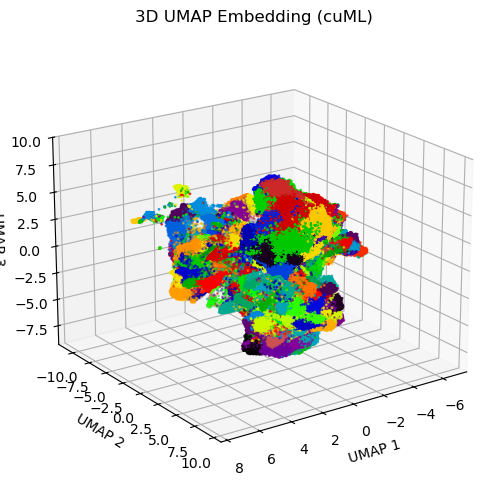

In [11]:
from mpl_toolkits.mplot3d import Axes3D
# 1. Transfer to NumPy
X_umap_3D = X_umap_gpu_3D.get()  # shape = (n_samples, 3)

num_labels = 300
cmap = plt.get_cmap('nipy_spectral', num_labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# If you have labels:
sc = ax.scatter(
    X_umap_3D[:,0], X_umap_3D[:,1], X_umap_3D[:,2], 
    c=kmeans_labels.get(), 
    cmap=cmap, 
    s=1)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.title('3D UMAP Embedding (cuML)')

# Rotate view: elev=30 degrees, azim=45 degrees
ax.view_init(elev=20, azim=55)

plt.show()


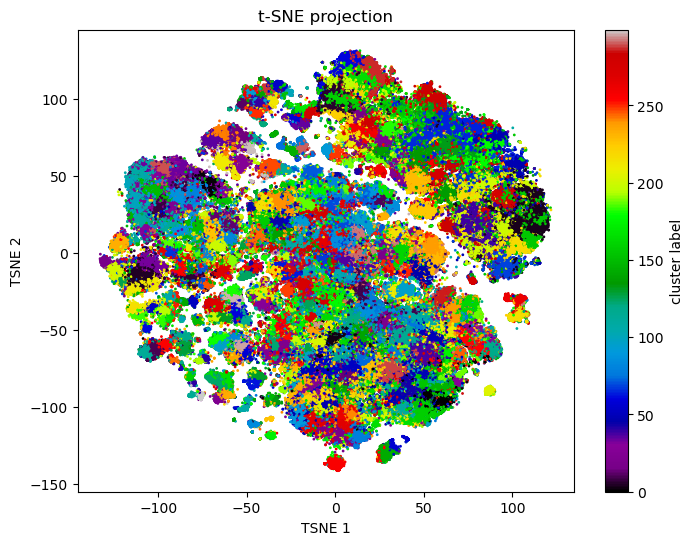

In [13]:
X_tsne = X_tsne_gpu.get()               # CuPy → NumPy

num_labels = 300
cmap = plt.get_cmap('nipy_spectral', num_labels)

plt.figure(figsize=(8,6))
plt.scatter(
    X_tsne[:,0], X_tsne[:,1], 
    c=kmeans_labels.get(), 
    cmap=cmap, 
    s=1)
plt.title("t-SNE projection")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.colorbar(label='cluster label')
plt.show()